## Import and data preparation

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tqdm
import scipy.io.wavfile as wav
!pip install git+https://github.com/bootphon/spectral.git
import spectral
import os
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

  Cloning https://github.com/bootphon/spectral.git to /tmp/pip-req-build-8l81477m
  Running command git clone -q https://github.com/bootphon/spectral.git /tmp/pip-req-build-8l81477m
  Created wheel for spectral: filename=spectral-0.1.7-cp36-cp36m-linux_x86_64.whl size=62803 sha256=818adbdfd8cb7771f5fcb64e58d2d0c77843e4a6f0bb395557e97cd52b1080b9
  Stored in directory: /tmp/pip-ephem-wheel-cache-ax7mjxz1/wheels/73/fd/30/6edc3e8687a96ba559a35ad0de5fa98922066731d716e4c22d
Successfully built spectral
11493376/11490434 [==============================] - 0s 0us/step


# Audio data (optional, bad results)

In [0]:
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 3166 (delta 3), reused 5 (delta 0), pack-reused 3157
Receiving objects: 100% (3166/3166), 23.93 MiB | 32.80 MiB/s, done.
Resolving deltas: 100% (72/72), done.


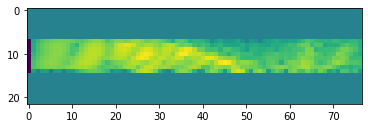

In [0]:
wavs = []
wavs_labels = []
wav_dir = 'free-spoken-digit-dataset/recordings'

for wavfile in os.listdir(wav_dir):
    fs, waveform = wav.read(wav_dir+'/'+wavfile)
    wavs.append(waveform)
    wavs_labels.append(wavfile[0])

def transform_wavs(wavs_list, feature_func):
    features = []
    for wav in wavs_list:
        features.append(feature_func.transform(wav[:1148]).flatten())
    return features

def pad(features, max_len=77*22):
    padded_features =[]
    for feat_file in features:
        max_len = max(max_len, feat_file.shape[0])
    for feat_file in features:
        pad_size = max_len - feat_file.shape[0]
        left_pad = pad_size // 2
        right_pad = pad_size - left_pad
        padded_features.append(np.pad(feat_file, ((left_pad, right_pad),), 'constant', constant_values=(0, 0)))
    return padded_features

melfbanks = spectral.Spectral(nfilt=77,
                    ncep=0,
                    do_dct=False,
                    lowerf=80,
                    upperf=8000,
                    alpha=0.98,
                    fs=16000,
                    frate=100,
                    wlen=0.01,
                    nfft=512,
                    compression='log',
                    do_deltas=False,
                    do_deltasdeltas=False)

train_feats = np.asarray(pad(transform_wavs(wavs, melfbanks)))

train_feats_1 = []
for i in range(len(train_feats)):
    if wavs_labels[i] == '1':
        new_feats = train_feats[i]
        new_feats = (new_feats - np.min(new_feats))/(np.max(new_feats) - np.min(new_feats))
        train_feats_1.append(new_feats)

train_feats_1 = np.array(train_feats_1)

plt.imshow(train_feats_1[5].reshape((22,77)))

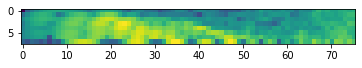

In [0]:
train_feats_1_cropped = np.array([train_feats_1[i].reshape((22,77))[7:15,1:].flatten() for i in range(train_feats_1.shape[0])])

plt.imshow(train_feats_1_cropped[0].reshape((8,76)))

In [0]:
n = train_feats_1_cropped.shape[0]
split_n = int(0.95*n) 
test_feats_1_cropped = train_feats_1_cropped[split_n:]
train_feats_1_cropped = train_feats_1_cropped[:split_n]

# Visual data (MNIST)

In [0]:
x_train_i, x_test_i = [[] for i in range(10)], [[] for i in range(10)]

for i in range(x_train.shape[0]):
    if y_train[i] == 1:
        x_train_i[int(y_train[i])].append(x_train[i]/255)

for k in range(10):
    x_train_i[k] = np.array(x_train_i[k])
    n = x_train_i[k].shape[0]
    split_n = int(0.8*n) 
    x_test_i[k] = x_train_i[k][split_n:]
    x_train_i[k] = x_train_i[k][:split_n]

# Restricted Boltzmann Machine with Synaptic Sampling

In [0]:
def sigmoid(u):
    return(1/(1+np.exp(-u)))


## Output of a layer


def output_v(w_vh, b_v, y_h):
    ''' Output of a visual layer from the hidden layer '''
    output = [sigmoid(sum([w_vh[i][j]*y_h[j] for j in range(n_h)])+b_v[i]) for i in range(n_v)]
    output_bolt = []
    for o in output:
        r = random.random()
        if r < o:
            res = 1
        else:
            res = 0
        output_bolt.append(res)
    return(np.array(output_bolt))

def output_h(w_vh, b_h, y_v):
    ''' Output of a hidden layer from the visual layer '''
    output = [sigmoid(sum([w_vh[j][i]*y_v[j] for j in range(n_v)])+b_h[i]) for i in range(n_h)]
    output_bolt = []
    for o in output:
        r = random.random()
        if r < o:
            res = 1
        else:
            res = 0
        output_bolt.append(res)
    return(np.array(output_bolt)) 

def output_h_hh(w_hh, b_hh, y_h):
    ''' Output of a double hidden layer from the hidden layer '''
    output = [sigmoid(sum([w_hh[j][i]*y_h[j] for j in range(n_h)])+b_hh[i]) for i in range(n_hh)]
    output_bolt = []
    for o in output:
        r = random.random()
        if r < o:
            res = 1
        else:
            res = 0
        output_bolt.append(res)
    return(np.array(output_bolt)) 

def output_hh_h(w_hh, b_h, y_hh):
    ''' Output of a hidden layer from the double hidden layer '''
    output = [sigmoid(sum([w_hh[i][j]*y_hh[j] for j in range(n_hh)])+b_h[i]) for i in range(n_h)]
    output_bolt = []
    for o in output:
        r = random.random()
        if r < o:
            res = 1
        else:
            res = 0
        output_bolt.append(res)
    return(np.array(output_bolt)) 

eta = 1e-4
N = 100


## Bayesian priors


def log_s_uniform(x):
    ''' Uniform prior '''
    return(0)
    
s1, s2, mu1, mu2 = 0.1, 0.1, 1.0, 0.0
def log_s_bi(x):
    ''' Bi gaussian prior '''
    exp1 = (1/s1)*np.exp(-(x-mu1)**2/(2*s1**2))
    exp2 = (1/s2)*np.exp(-(x-mu2)**2/(2*s2**2))
    norma1 = (x-mu1)/s1
    norma2 = (x-mu2)/s2
    result = (norma1*exp1 + norma2*exp2)/max(0.00001,exp1 + exp2)
    return(result)

s1, s2, s3, mu1, mu2, mu3 = 0.07, 0.07, 0.07, 1.0, 0.0, 0.5
def log_s_tri(x):
    ''' Tri Gaussian prior '''
    exp1 = (1/s1)*np.exp(-(x-mu1)**2/(2*s1**2))
    exp2 = (1/s2)*np.exp(-(x-mu2)**2/(2*s2**2))
    exp3 = (1/s3)*np.exp(-(x-mu3)**2/(2*s3**2))
    norma1 = (x-mu1)/s1
    norma2 = (x-mu2)/s2
    norma3 = (x-mu3)/s3
    result = (norma1*exp1 + norma2*exp2 + norma3*exp3)/max(0.00001,exp1 + exp2 + exp3)
    return(result) 

s_uni, mu_uni = 0.2, 0.5
def log_s_uni(x): #Not finished implemented
    exp_uni = (1/s_uni)*np.exp(-(x-mu_uni)**2/(2*s_uni**2))
    norma_uni = (x-mu_uni)/s_uni
    norma2 = (x-mu2)/s2
    result = (norma1*exp1 + norma2*exp2)/max(0.00001,exp1 + exp2)
    return(result)
    

## Return the values needed for weight updates


def loop(y_v, w_vh, b_v, b_h, eta, N, log_s):
    ''' Return ^y_v, ^y_h, y_v and y_h for update '''
    y_h = output_h(w_vh, b_h, y_v)
    first_y_h = y_h.copy()
    for i in range(5):
        y_v = output_v(w_vh, b_v, y_h)
        if i == 0:
            first_y_v = y_v.copy()
        y_h = output_h(w_vh, b_h, y_v)
    return(first_y_h, first_y_v, y_v, y_h)

def loop_hh(y_v, w_vh, w_hh, b_v, b_h, b_hh, eta, N, log_s):
    ''' Return ^y_v, ^y_h, y_v and y_h for update, for double hidden layers network'''
    y_h = output_h(w_vh, b_h, y_v)
    first_y_h = y_h.copy()
    y_hh = output_h_hh(w_hh, b_hh, y_h)
    first_y_hh = y_hh.copy()
    y_h = output_hh_h(w_hh, b_h, y_hh)
    for i in range(5):
        y_v = output_v(w_vh, b_v, y_h)
        if i == 0:
            first_y_v = y_v.copy()
        y_h = output_h(w_vh, b_h, y_v)
        y_hh = output_h_hh(w_hh, b_hh, y_h)
        y_h = output_hh_h(w_hh, b_h, y_hh)
    return(first_y_h, first_y_hh, first_y_v, y_v, y_h, y_hh)


## Update weights


def update(w_vh, b_v, b_h, x, z, xh, zh, eta, N, log_s):
    ''' Update the weights and biases '''
    for iv in range(n_v):
        for jh in range(n_h):
              w_vh[iv,jh] += eta*(log_s(w_vh[iv,jh]) + N*(z[jh]*x[iv] - zh[jh]*xh[iv])) #+ np.sqrt(2*eta)*np.random.normal()
    for iv in range(n_v):
        b_v[iv] += eta*N*(x[iv] - xh[iv])# + np.sqrt(2*eta)*np.random.normal()
    for jh in range(n_h):
        b_h[jh] += eta*N*(z[jh] - zh[jh]) #+ np.sqrt(2*eta)*np.random.normal()
    return(w_vh, b_v, b_h)  


def update_hh(w_vh, w_hh, b_v, b_h, b_hh, x, z, zz, xh, zh, zzh, eta, N, log_s):
    ''' Update the weights and biases for a double hidden layers network'''
    for iv in range(n_v):
        for jh in range(n_h):
              w_vh[iv,jh] += eta*(log_s(w_vh[iv,jh]) + N*(z[jh]*x[iv] - zh[jh]*xh[iv])) + np.sqrt(2*eta)*np.random.normal()
    for ih in range(n_h):
        for jhh in range(n_hh):
              w_hh[ih,jhh] += eta*(log_s(w_hh[ih,jhh]) + N*(zz[jhh]*z[ih] - zzh[jhh]*z[ih])) + np.sqrt(2*eta)*np.random.normal()
    for iv in range(n_v):
        b_v[iv] += eta*N*(x[iv] - xh[iv]) + np.sqrt(2*eta)*np.random.normal()
    for jh in range(n_h):
        b_h[jh] += eta*N*(z[jh] - zh[jh]) + np.sqrt(2*eta)*np.random.normal()
    for jhh in range(n_hh):
        b_hh[jhh] += eta*N*(zz[jhh] - zzh[jhh]) + np.sqrt(2*eta)*np.random.normal()
    return(w_vh, w_hh, b_v, b_h, b_hh)  


## Training function for one image


# For audio inputs
def new_y(image):
    y = []
    for pix in image.flatten():
        if 0.87 < pix:
            res = 1
        else:
            res = 0
        y.append(res)
    return(np.array(y))

# For visual images inputs (normal)
def new_y(image):
    y = []
    for pix in image.flatten():
        r = random.random()
        if r < pix:
            res = 1
        else:
            res = 0
        y.append(res)
    return(np.array(y))

def train(image, w_vh, b_v, b_h, eta, N, log_s):
    ''' Full training loop for one image '''
    y_v = new_y(image)
    input_y_v = y_v.copy()

    y_h, first_y_v, yh_v, yh_h = loop(y_v, w_vh, b_v, b_h, eta, N, log_s)

    w_vh, b_v, b_h = update(w_vh, b_v, b_h, y_v, y_h, yh_v, yh_h, eta, N, log_s)

    error = np.mean(abs(input_y_v - first_y_v))
    
    return(w_vh, b_v, b_h, error)

def train_hh(image, w_vh, w_hh, b_v, b_h, b_hh, eta, N, log_s):
    ''' Full training loop for one image (double hidden network)'''
    y_v = new_y(image)
    input_y_v = y_v.copy()
    
    y_h, y_hh, first_y_v, yh_v, yh_h, yh_hh = loop_hh(y_v, w_vh, w_hh, b_v, b_h, b_hh, eta, N, log_s)

    w_vh, w_hh, b_v, b_h, b_hh = update_hh(w_vh, w_hh, b_v, b_h, b_hh, y_v, y_h, y_hh, yh_v, yh_h, yh_hh, eta, N, log_s)

    error = np.mean(abs(input_y_v - first_y_v))
    
    return(w_vh, w_hh, b_v, b_h, b_hh, error)


## Reconstruction of an image for train and test losses


def reconstruct(img, w_vh, b_h, b_v):
    ''' Reconstruct an image after one passage through the hidden layer '''
    y_v = new_y(img)
    y_h = output_h(w_vh, b_h, y_v)
    y_v = output_v(w_vh, b_v, y_h)
    return(y_v)#.reshape((28,28))

def reconstruct_hh(img, w_vh, w_hh, b_h, b_v, b_hh):
    ''' Reconstruct an image after one passage through the hidden layer (double hidden network)'''
    y_v = new_y(img)
    y_h = output_h(w_vh, b_h, y_v)
    y_hh = output_h_hh(w_hh, b_hh, y_h)
    y_h = output_hh_h(w_hh, b_h, y_hh)
    y_v = output_v(w_vh, b_v, y_h)
    return(y_v)#.reshape((28,28)

def criterion(inpu, outpu):
    return(np.mean(abs(inpu.flatten()-outpu.flatten())))

def test_loss(w_vh, b_h, b_v, x_testi):
    ''' Calculate a full test loss '''
    total_loss = 0
    for i in range(x_testi.shape[0]):
        input_i = x_testi[i]
        output_i = reconstruct(input_i, w_vh, b_h, b_v)
        total_loss += criterion(input_i, output_i)
    return(total_loss/x_testi.shape[0])

def test_loss_hh(w_vh, w_hh, b_h, b_v, b_hh, x_testi):
    ''' Calculate a full test loss (double hidden layer)'''
    total_loss = 0
    for i in range(x_testi.shape[0]):
        input_i = x_testi[i]
        output_i = reconstruct_hh(input_i, w_vh, w_hh, b_h, b_v, b_hh)
        total_loss += criterion(input_i, output_i)
    return(total_loss/x_testi.shape[0])

# Parameter initialisation (for different inputs/networks)

Generally already done in the experiences cells.

In [0]:
# Initialisation WAV files

#wav_700
n_v = 616 #784
n_h = 15 #9
b_v = np.zeros((n_v))
b_h = np.zeros((n_h))
w_vh = np.zeros((n_v,n_h))
for iv in range(n_v):
    for jh in range(n_h):
        w_vh[iv,jh] = np.random.normal(0,0.25)
for iv in range(n_v):
        b_v[iv] = np.random.normal(-1,0.25)
for jh in range(n_h):
        b_h[jh] = np.random.normal(-1,0.25)

In [0]:
# Initialisation Normal image - double hidden

n_v = 28*28 #784
n_h = 9 #9
n_hh = 9 #9
b_v = np.zeros((n_v))
b_h = np.zeros((n_h))
b_hh = np.zeros((n_hh))
w_vh = np.zeros((n_v,n_h))
w_hh = np.zeros((n_h,n_hh))
for iv in range(n_v):
    for jh in range(n_h):
        w_vh[iv,jh] = np.random.normal(0,0.25)
for ih in range(n_h):
    for jhh in range(n_hh):
        w_hh[ih,jhh] = np.random.normal(0,0.25)
for iv in range(n_v):
        b_v[iv] = np.random.normal(-1,0.25)
for jh in range(n_h):
        b_h[jh] = np.random.normal(-1,0.25)
for jhh in range(n_hh):
        b_hh[jhh] = np.random.normal(-1,0.25)

In [0]:
# Initialisation Normal image

n_v = 28*28 #784
n_h = 100 #9
b_v = np.zeros((n_v))
b_h = np.zeros((n_h))
w_vh = np.zeros((n_v,n_h))
for iv in range(n_v):
    for jh in range(n_h):
        w_vh[iv,jh] = np.random.normal(0,0.25)
for iv in range(n_v):
        b_v[iv] = np.random.normal(-1,0.25)
for jh in range(n_h):
        b_h[jh] = np.random.normal(-1,0.25)

# Experiences with training loops.

Run the cell wanted for a given experience.

Normal full training loop

In [0]:
index_train = 1
len_training = int(0.5*x_train_i[index_train].shape[0]) # You can limit the size of the training

n_v = 28*28  #784
n_h = 9    #9
b_v = np.zeros((n_v))
b_h = np.zeros((n_h))
w_vh = np.zeros((n_v,n_h))
for iv in range(n_v):
    for jh in range(n_h):
        w_vh[iv,jh] = np.random.normal(0,0.25)
for iv in range(n_v):
        b_v[iv] = np.random.normal(-1,0.25)
for jh in range(n_h):
        b_h[jh] = np.random.normal(-1,0.25)

full_error = []
test_loss_list = []
for i in tqdm.tqdm(range(len_training)): 
    x = x_train_i[index_train][i]
    w_vh, b_v, b_h, error = train(x, w_vh, b_v, b_h, eta, N, log_s_bi)
    full_error.append(error)

plt.plot(full_error)

Full training loop with viusalisations included (arrays)

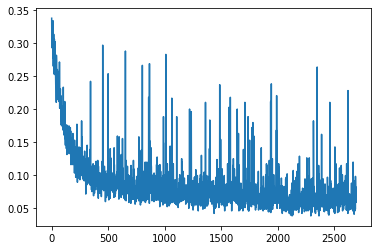

In [0]:
index_train = 1
len_training = int(0.5*x_train_i[index_train].shape[0]) # You can limit the size of the training

n_v = 28*28 #784
n_h = 9     #9
b_v = np.zeros((n_v))
b_h = np.zeros((n_h))
w_vh = np.zeros((n_v,n_h))
for iv in range(n_v):
    for jh in range(n_h):
        w_vh[iv,jh] = np.random.normal(0,0.25)
for iv in range(n_v):
        b_v[iv] = np.random.normal(-1,0.25)
for jh in range(n_h):
        b_h[jh] = np.random.normal(-1,0.25)

w_vh00 = []
w_vh2010 = []
w_vh1414 = []
b_v00 = []
b_v2010 = []
b_v1414 = []
b_h_list = []
b_v_m03 = []
b_v_m05 = []
b_v_m07 = []
b_v_m1 = []


full_error = []
test_loss_list = []
for i in tqdm.notebook.tqdm(range(len_training)):
    x = x_train_i[index_train][i]
    w_vh, b_v, b_h, error = train(x, w_vh, b_v, b_h, eta, N, log_s_bi)
    w_vh00.append(np.copy(w_vh[0]))
    w_vh2010.append(np.copy(w_vh[20*28+10]))
    w_vh1414.append(np.copy(w_vh[14*28+14]))
    b_v00.append(np.copy(b_v[0]))
    b_v2010.append(np.copy(b_v[20*28+10]))
    b_v1414.append(np.copy(b_v[14*28+14]))
    b_v_m03.append(sum(b_v > -0.3))
    b_v_m05.append(sum(b_v > -0.5))
    b_v_m07.append(sum(b_v > -0.7))
    b_v_m1.append(sum(b_v > -1))
    b_h_list.append(np.copy(b_h))
    full_error.append(error)
    if i%500 == 0 and i != 0:
        test_loss_list.append(test_loss(w_vh, b_h, b_v, x_test_i[index_train]))

plt.plot(full_error)

Training experience for dataset of 1, 2 and then 1 again.

In [0]:
n_v = 28*28 #784
n_h = 9 #9
b_v = np.zeros((n_v))
b_h = np.zeros((n_h))
w_vh = np.zeros((n_v,n_h))
for iv in range(n_v):
    for jh in range(n_h):
        w_vh[iv,jh] = np.random.normal(0,0.25)
for iv in range(n_v):
        b_v[iv] = np.random.normal(-1,0.25)
for jh in range(n_h):
        b_h[jh] = np.random.normal(-1,0.25)

w_vh00 = []
w_vh2010 = []
w_vh1414 = []
b_v00 = []
b_v2010 = []
b_v1414 = []
b_h_list = []
b_v_m03 = []
b_v_m05 = []
b_v_m07 = []
b_v_m1 = []

full_error = []
test_loss_list = []
for i in tqdm.tqdm(range(x_train_i[1].shape[0])):
    x = x_train_i[1][i]
    w_vh, b_v, b_h, error = train(x, w_vh, b_v, b_h, eta, N, log_s_bi) #uniform
    w_vh00.append(np.copy(w_vh[0]))
    w_vh2010.append(np.copy(w_vh[20*28+10]))
    w_vh1414.append(np.copy(w_vh[14*28+14]))
    b_v00.append(np.copy(b_v[0]))
    b_v2010.append(np.copy(b_v[20*28+10]))
    b_v1414.append(np.copy(b_v[14*28+14]))
    b_v_m03.append(sum(b_v > -0.3))
    b_v_m05.append(sum(b_v > -0.5))
    b_v_m07.append(sum(b_v > -0.7))
    b_v_m1.append(sum(b_v > -1))
    b_h_list.append(np.copy(b_h))
    full_error.append(error)
    if i%500 == 0 and i != 0:
        test_loss_list.append(test_loss(w_vh, b_h, b_v, x_test_i[1]))
        
for i in tqdm.tqdm(range(x_train_i[2].shape[0])):
    x = x_train_i[2][i]
    w_vh, b_v, b_h, error = train(x, w_vh, b_v, b_h, eta, N, log_s_bi) #uniform
    w_vh00.append(np.copy(w_vh[0]))
    w_vh2010.append(np.copy(w_vh[20*28+10]))
    w_vh1414.append(np.copy(w_vh[14*28+14]))
    b_v00.append(np.copy(b_v[0]))
    b_v2010.append(np.copy(b_v[20*28+10]))
    b_v1414.append(np.copy(b_v[14*28+14]))
    b_v_m03.append(sum(b_v > -0.3))
    b_v_m05.append(sum(b_v > -0.5))
    b_v_m07.append(sum(b_v > -0.7))
    b_v_m1.append(sum(b_v > -1))
    b_h_list.append(np.copy(b_h))
    full_error.append(error)
    if i%500 == 0 and i != 0:
        test_loss_list.append(test_loss(w_vh, b_h, b_v, x_test_i[2]))

for i in tqdm.tqdm(range(x_train_i[1].shape[0])):
    x = x_train_i[1][i]
    w_vh, b_v, b_h, error = train(x, w_vh, b_v, b_h, eta, N, log_s_bi) #uniform
    w_vh00.append(np.copy(w_vh[0]))
    w_vh2010.append(np.copy(w_vh[20*28+10]))
    w_vh1414.append(np.copy(w_vh[14*28+14]))
    b_v00.append(np.copy(b_v[0]))
    b_v2010.append(np.copy(b_v[20*28+10]))
    b_v1414.append(np.copy(b_v[14*28+14]))
    b_v_m03.append(sum(b_v > -0.3))
    b_v_m05.append(sum(b_v > -0.5))
    b_v_m07.append(sum(b_v > -0.7))
    b_v_m1.append(sum(b_v > -1))
    b_h_list.append(np.copy(b_h))
    full_error.append(error)
    if i%500 == 0 and i != 0:
        test_loss_list.append(test_loss(w_vh, b_h, b_v, x_test_i[1]))

plt.plot(full_error)

"Lesion" experience. We reset half of weights and biases two times.

In [0]:
n_v = 28*28 #784
n_h = 9 #9
b_v = np.zeros((n_v))
b_h = np.zeros((n_h))
w_vh = np.zeros((n_v,n_h))
for iv in range(n_v):
    for jh in range(n_h):
        w_vh[iv,jh] = np.random.normal(0,0.25)
for iv in range(n_v):
        b_v[iv] = np.random.normal(-1,0.25)
for jh in range(n_h):
        b_h[jh] = np.random.normal(-1,0.25)

half_nv = int(n_v/2)
half_nh = int(n_h/2)

w_vh00 = []
w_vh2010 = []
w_vh1414 = []
b_v00 = []
b_v2010 = []
b_v1414 = []
b_h_list = []
b_v_m03 = []
b_v_m05 = []
b_v_m07 = []
b_v_m1 = []

full_error = []
test_loss_list = []
for i in tqdm.tqdm(range(x_train_i[1].shape[0])):
    x = x_train_i[1][i]
    w_vh, b_v, b_h, error = train(x, w_vh, b_v, b_h, eta, N, log_s_uniform) #uniform
    w_vh00.append(np.copy(w_vh[0]))
    w_vh2010.append(np.copy(w_vh[20*28+10]))
    w_vh1414.append(np.copy(w_vh[14*28+14]))
    b_v00.append(np.copy(b_v[0]))
    b_v2010.append(np.copy(b_v[20*28+10]))
    b_v1414.append(np.copy(b_v[14*28+14]))
    b_v_m03.append(sum(b_v > -0.3))
    b_v_m05.append(sum(b_v > -0.5))
    b_v_m07.append(sum(b_v > -0.7))
    b_v_m1.append(sum(b_v > -1))
    b_h_list.append(np.copy(b_h))
    full_error.append(error)
    if i%500 == 0 and i != 0:
        test_loss_list.append(test_loss(w_vh, b_h, b_v, x_test_i[1]))
    if i%2000 == 0 and i != 0:
        # Lésion
        listv, listh = list(range(n_v)), list(range(n_h))
        random.shuffle(listv)
        random.shuffle(listh)
        for iv in listv[:half_nv]:
            for jh in listh[:half_nh]:
                w_vh[iv,jh] = np.random.normal(0,0.25)
        listv, listh = list(range(n_v)), list(range(n_h))
        random.shuffle(listv)
        random.shuffle(listh)
        for iv in listv[:half_nv]:
                b_v[iv] = np.random.normal(-1,0.25)
        for jh in listh[:half_nh]:
                b_h[jh] = np.random.normal(-1,0.25)
                
        test_loss_list.append(test_loss(w_vh, b_h, b_v, x_test_i[1]))

plt.plot(full_error)

Double hidden layers network experience

In [0]:
n_v = 28*28 #784
n_h = 9 #9
n_hh = 5 #9
b_v = np.zeros((n_v))
b_h = np.zeros((n_h))
b_hh = np.zeros((n_hh))
w_vh = np.zeros((n_v,n_h))
w_hh = np.zeros((n_h,n_hh))
for iv in range(n_v):
    for jh in range(n_h):
        w_vh[iv,jh] = np.random.normal(0,0.25)
for ih in range(n_h):
    for jhh in range(n_hh):
        w_hh[ih,jhh] = np.random.normal(0,0.25)
for iv in range(n_v):
        b_v[iv] = np.random.normal(-1,0.25)
for jh in range(n_h):
        b_h[jh] = np.random.normal(-1,0.25)
for jhh in range(n_hh):
        b_hh[jhh] = np.random.normal(-1,0.25)

w_vh00 = []
w_vh2010 = []
w_vh1414 = []
b_v00 = []
b_v2010 = []
b_v1414 = []
b_h_list = []
b_v_m03 = []
b_v_m05 = []
b_v_m07 = []
b_v_m1 = []
b_hh_list = []

full_error = []
test_loss_list = []
for i in tqdm.tqdm(range(x_train_i[1].shape[0])):
    x = x_train_i[1][i]
    w_vh, w_hh, b_v, b_h, b_hh, error = train_hh(x, w_vh, w_hh, b_v, b_h, b_hh, eta, N, log_s_bi)
    w_vh00.append(np.copy(w_vh[0]))
    w_vh2010.append(np.copy(w_vh[20*28+10]))
    w_vh1414.append(np.copy(w_vh[14*28+14]))
    b_v00.append(np.copy(b_v[0]))
    b_v2010.append(np.copy(b_v[20*28+10]))
    b_v1414.append(np.copy(b_v[14*28+14]))
    b_v_m03.append(sum(b_v > -0.3))
    b_v_m05.append(sum(b_v > -0.5))
    b_v_m07.append(sum(b_v > -0.7))
    b_v_m1.append(sum(b_v > -1))
    b_h_list.append(np.copy(b_h))
    b_hh_list.append(np.copy(b_hh))
    full_error.append(error)
    if i%500 == 0 and i != 0:
        test_loss_list.append(test_loss_hh(w_vh, w_hh, b_h, b_v, b_hh, x_test_i[1]))

plt.plot(full_error)

MFCC Audio training experience

In [0]:
n_v = 608 
n_h = 9
b_v = np.zeros((n_v))
b_h = np.zeros((n_h))
w_vh = np.zeros((n_v,n_h))
for iv in range(n_v):
    for jh in range(n_h):
        w_vh[iv,jh] = np.random.normal(0,0.25)
for iv in range(n_v):
        b_v[iv] = np.random.normal(-1,0.25)
for jh in range(n_h):
        b_h[jh] = np.random.normal(-1,0.25)

w_vh00 = []
w_vh2010 = []
w_vh1414 = []
b_v00 = []
b_v2010 = []
b_v1414 = []
b_h_list = []
b_v_m03 = []
b_v_m05 = []
b_v_m07 = []
b_v_m1 = []

full_error = []
test_loss_list = []
for k in range(5):
    for i in tqdm.tqdm(range(train_feats_1_cropped.shape[0])):
        x = train_feats_1_cropped[i]
        w_vh, b_v, b_h, error = train(x, w_vh, b_v, b_h, eta, N, log_s_bi) #uniform
        w_vh00.append(np.copy(w_vh[0]))
        w_vh2010.append(np.copy(w_vh[20*28+10]))
        w_vh1414.append(np.copy(w_vh[14*28+14]))
        b_v00.append(np.copy(b_v[0]))
        b_v2010.append(np.copy(b_v[20*28+10]))
        b_v1414.append(np.copy(b_v[14*28+14]))
        b_v_m03.append(sum(b_v > -0.3))
        b_v_m05.append(sum(b_v > -0.5))
        b_v_m07.append(sum(b_v > -0.7))
        b_v_m1.append(sum(b_v > -1))
        b_h_list.append(np.copy(b_h))
        full_error.append(error)
        if i==0 or i==95 or i==189:
            test_loss_list.append(test_loss(w_vh, b_h, b_v, test_feats_1_cropped))

plt.plot(full_error)

## Results visualisations

Training error

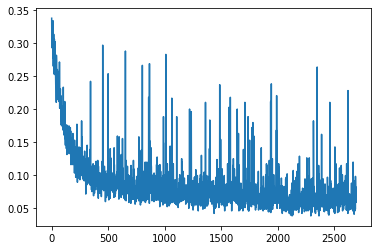

In [0]:
plt.plot(full_error)
plt.show()

Test error

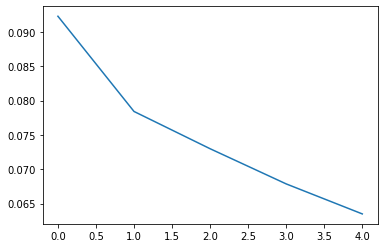

In [0]:
plt.plot(test_loss_list)
plt.show()

Number of bias values over -0.7 and -1

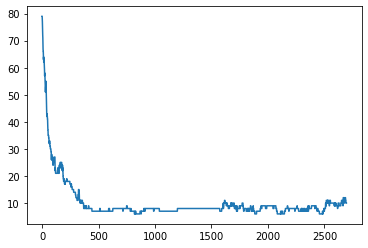

In [0]:
plt.plot(b_v_m07)
plt.show()

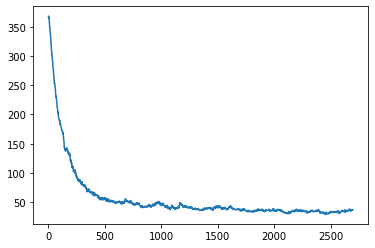

In [0]:
plt.plot(b_v_m1)
plt.show()

Evolution of the values of weights at pixel 0,0; 14,14; 20;10

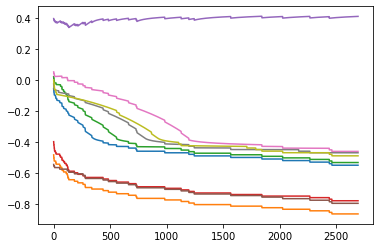

In [0]:
plt.plot(w_vh00)
plt.show()

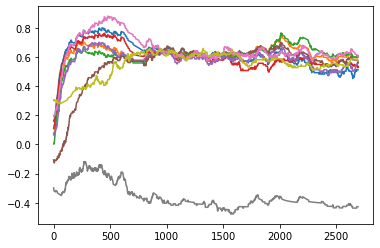

In [0]:
plt.plot(w_vh1414)
plt.show()

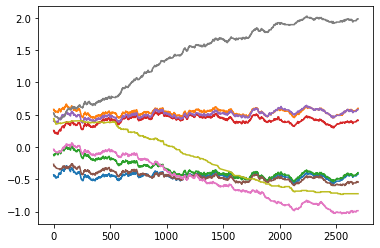

In [0]:
plt.plot(w_vh2010)
plt.show()

Evolution of the values of bias at pixel 0,0; 14,14; 20,10, and all hidden bias

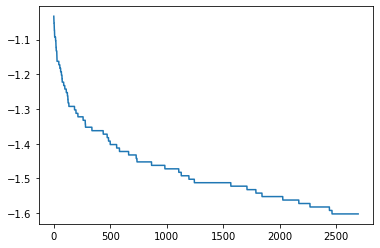

In [0]:
plt.plot(b_v00)
plt.show()

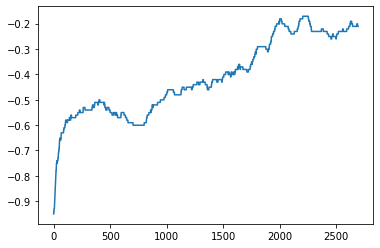

In [0]:
plt.plot(b_v1414)
plt.show()

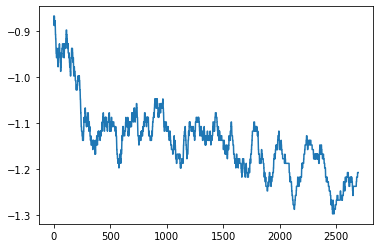

In [0]:
plt.plot(b_v2010)
plt.show()

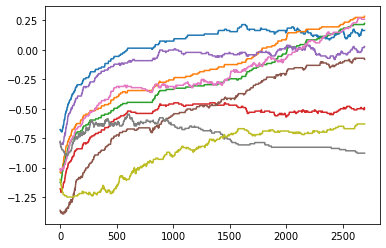

In [0]:
plt.plot(b_h_list)
plt.show()

Histogram of the visual weights and bias

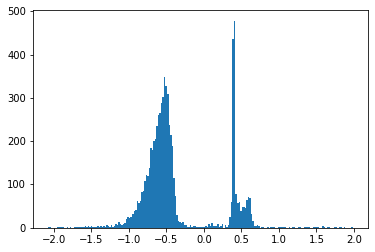

In [0]:
plt.hist(w_vh.flatten(), bins=200)
plt.show()

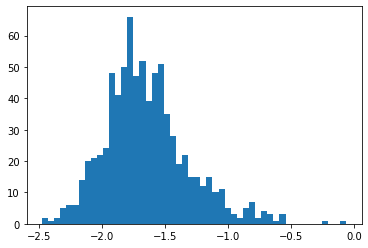

In [0]:
plt.hist(b_v.flatten(), bins=50)
plt.show()

In [0]:
 #Double hidden only
#plt.hist(w_hh.flatten(), bins=20)
#plt.plot(b_hh_list)
#plt.hist(b_hh.flatten(), bins=4)

Example reconstruction of test images

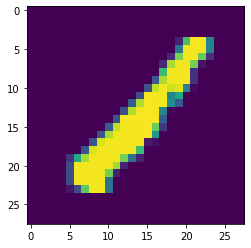

In [0]:
image = x_test_i[1][0]
y_v = new_y(image)
y_h = output_h(w_vh, b_h, y_v)
y_v = output_v(w_vh, b_v, y_h)
newy = y_v.reshape((28,28))

# Original image
plt.imshow(image)
plt.show()

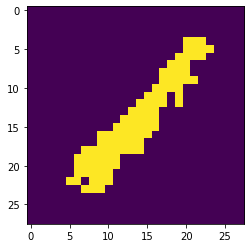

In [0]:
# Binarized input image
plt.imshow(new_y(image).reshape((28,28)))
plt.show()

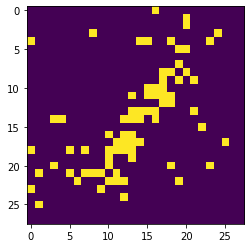

In [0]:
# Output
plt.imshow(newy)
plt.show()